In [2]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Dataset Head:
    satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  

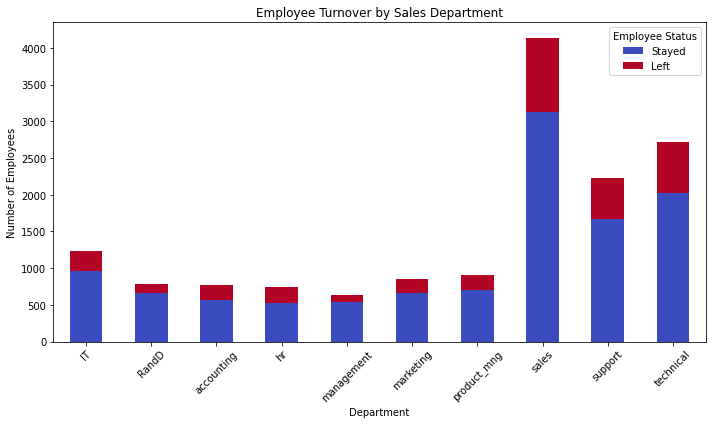

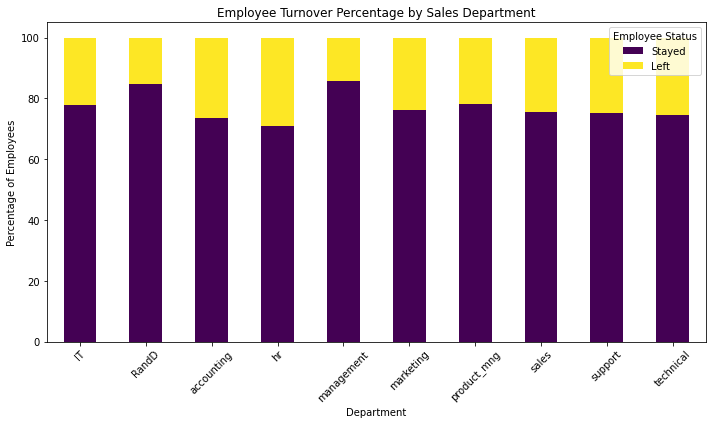

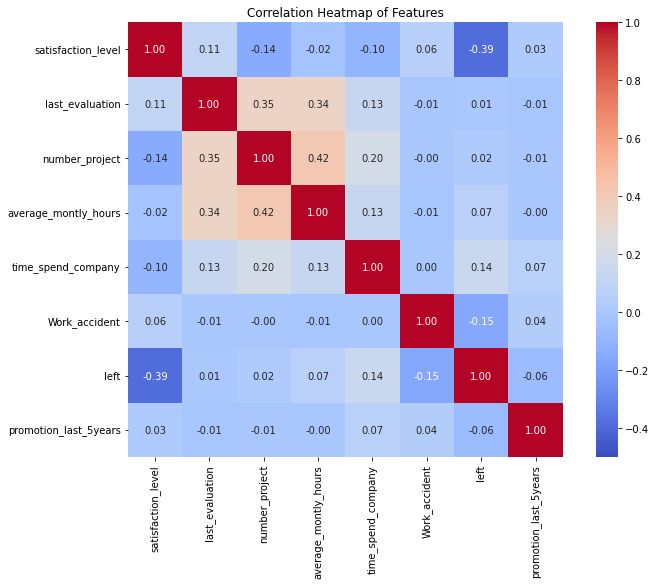


Top Factors Contributing to Employee Turnover:
left                     1.000000
time_spend_company       0.144822
average_montly_hours     0.071287
number_project           0.023787
last_evaluation          0.006567
promotion_last_5years   -0.061788
Work_accident           -0.154622
satisfaction_level      -0.388375
Name: left, dtype: float64


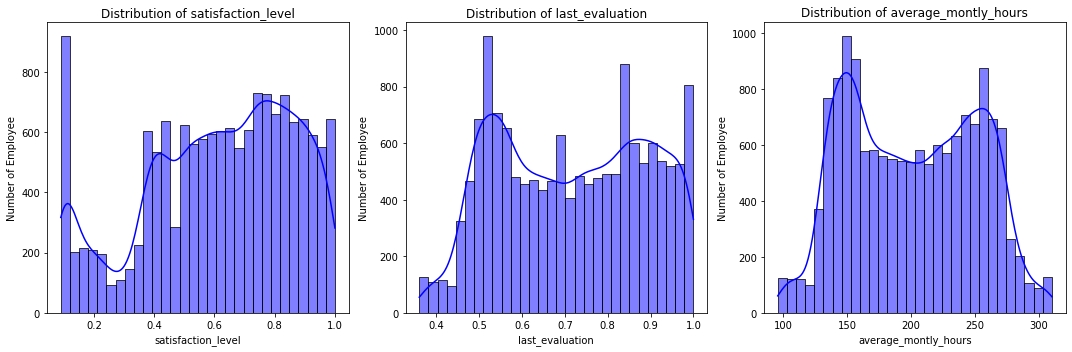

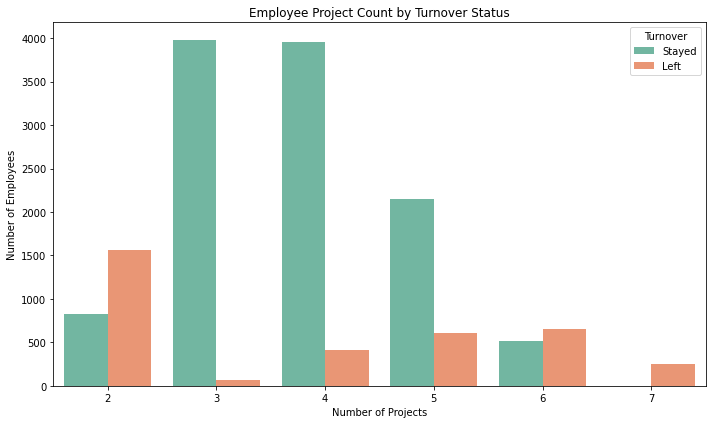


Inference:
1. Employees with very few or very high project counts are more likely to leave.
2. Moderate project counts seem to have a lower turnover rate, indicating a balanced workload might reduce turnover.


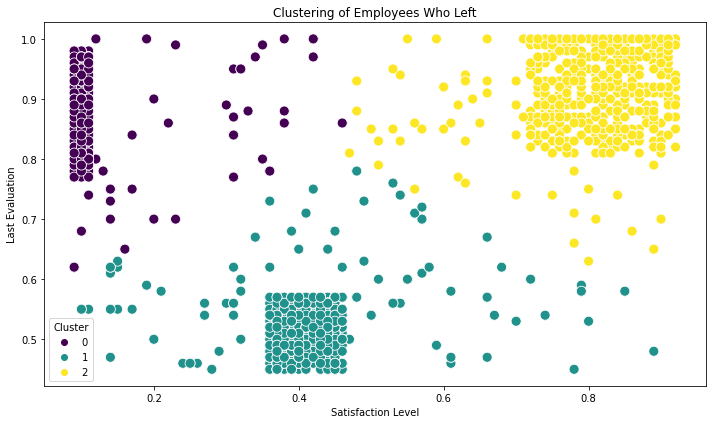

/voc/work/.local/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Class distribution before SMOTE:
0    9142
1    2857
Name: left, dtype: int64

Class distribution after SMOTE:
0    9142
1    9142
Name: left, dtype: int64

Cross-Validation Scores: [0.97757725 0.98195242 0.98085863 0.97757725 0.98468271]
Mean Accuracy: 0.9805296517754087
Standard Deviation: 0.002713439800847215

Confusion Matrix:
 [[2267   19]
 [  16  698]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



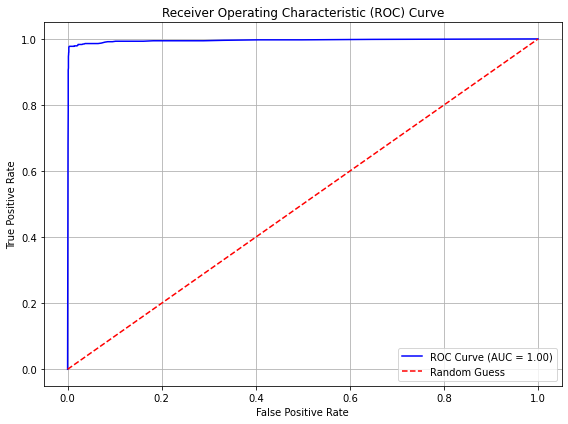

AUC Score: 1.00


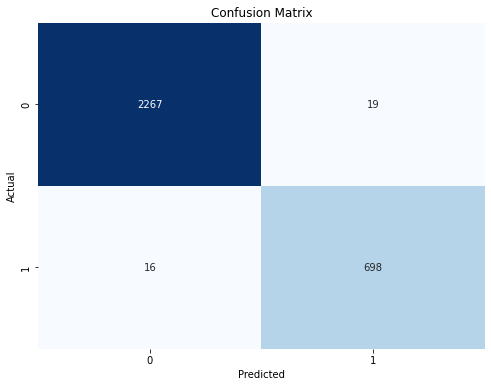


Retention Strategies for Targeted Employees:
1. Improve Job Satisfaction: Address factors like workload, work-life balance, and recognition to enhance employee satisfaction.
2. Career Development: Provide opportunities for skill development, training, and career progression.
3. Competitive Compensation: Ensure salaries and benefits are competitive within the industry.
4. Employee Engagement: Foster a positive work culture through team-building activities, feedback sessions, and open communication.
5. Performance Management: Regularly evaluate and reward high-performing employees to boost morale and motivation.
6. Flexible Work Options: Offer remote work, flexible hours, or hybrid models to accommodate employee preferences.
7. Address High Turnover Departments: Focus on departments with higher turnover rates and identify specific issues causing dissatisfaction.
8. Exit Interviews: Conduct exit interviews to understand reasons for leaving and implement changes to address recurring conce

In [3]:
# Employee Turnover Prediction & Analysis
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Set max CPU count for parallel processing
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

# Load dataset
def load_data(file_path):
    """Loads the dataset and checks if the file exists."""
    if os.path.exists(file_path):
        return pd.read_csv(file_path, encoding='ISO-8859-1')
    else:
        raise FileNotFoundError(f"The file '{file_path}' does not exist. Please check the file path.")

# Data Quality Check
def check_missing_values(df):
    """Checks for missing values in the dataset."""
    missing_values = df.isnull().sum()
    if missing_values.any():
        print("\nMissing values found in the dataset:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found in the dataset.")

# Visualize Employee Turnover by Department
def plot_turnover_by_department(df):
    """Plots employee turnover count and percentage by department."""
    turnover_by_sales = df.groupby(['sales', 'left']).size().unstack()
    
    # Absolute Count
    turnover_by_sales.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='coolwarm')
    plt.title('Employee Turnover by Sales Department')
    plt.xlabel('Department')
    plt.ylabel('Number of Employees')
    plt.legend(['Stayed', 'Left'], title='Employee Status')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Percentage Turnover
    turnover_percentage_by_sales = turnover_by_sales.div(turnover_by_sales.sum(axis=1), axis=0) * 100
    turnover_percentage_by_sales.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title('Employee Turnover Percentage by Sales Department')
    plt.xlabel('Department')
    plt.ylabel('Percentage of Employees')
    plt.legend(['Stayed', 'Left'], title='Employee Status')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Correlation Heatmap
def plot_correlation_heatmap(df):
    """Displays a correlation heatmap to understand factors affecting turnover."""
    plt.figure(figsize=(12, 8))
    numeric_data = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_data.corr()

    sns.heatmap(correlation_matrix, annot=True, square=True, fmt=".2f",
                cmap="coolwarm", vmin=-0.5, vmax=1, cbar=True)
    plt.title("Correlation Heatmap of Features")
    plt.show()

    if 'left' in correlation_matrix.columns:
        turnover_correlation = correlation_matrix['left'].sort_values(ascending=False)
        print("\nTop Factors Contributing to Employee Turnover:")
        print(turnover_correlation)

# Draw the distribution plot of satisfaction_level, last_evaluation, average_montly_hours
def plot_distributions(df):
    """Plots the distribution of satisfaction_level, last_evaluation, and average_montly_hours."""
    features = ['satisfaction_level', 'last_evaluation', 'average_montly_hours']
    plt.figure(figsize=(15, 5))
    
    for i, feature in enumerate(features, 1):
        plt.subplot(1, 3, i)
        sns.histplot(df[feature], kde=True, color='blue', bins=30)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Number of Employee')
    
    plt.tight_layout()
    plt.show()

# Draw the bar plot of the employee project count of both employees who left and stayed in the organization (use column number_project and hue column left), and give your inferences from the plot. 
def plot_project_count_by_turnover(df):
    """Plots the project count of employees who left and stayed in the organization."""
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='number_project', hue='left', palette='Set2')
    plt.title('Employee Project Count by Turnover Status')
    plt.xlabel('Number of Projects')
    plt.ylabel('Number of Employees')
    plt.legend(title='Turnover', labels=['Stayed', 'Left'])
    plt.tight_layout()
    plt.show()

    # Inference
    print("\nInference:")
    print("1. Employees with very few or very high project counts are more likely to leave.")
    print("2. Moderate project counts seem to have a lower turnover rate, indicating a balanced workload might reduce turnover.")

# Clustering of Employees Who Left
def cluster_employees_who_left(df):
    """Clusters employees who left based on satisfaction and evaluation scores."""
    left_employees = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]

    # Normalize data
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(left_employees)

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=123, n_init=10)
    left_employees['cluster'] = kmeans.fit_predict(normalized_data)

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=left_employees['satisfaction_level'],
        y=left_employees['last_evaluation'],
        hue=left_employees['cluster'],
        palette='viridis',
        s=100
    )
    plt.title('Clustering of Employees Who Left')
    plt.xlabel('Satisfaction Level')
    plt.ylabel('Last Evaluation')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# Handle the left Class Imbalance using the SMOTE technique
def handle_class_imbalance(df):
    """Handles class imbalance in the dataset using SMOTE."""
    # Separate features and target variable
    X = df.drop('left', axis=1)
    y = df['left']

    # Convert categorical variables to dummy/indicator variables
    X = pd.get_dummies(X, drop_first=True)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

    # Apply SMOTE to balance the classes in the training set
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print("\nClass distribution before SMOTE:")
    print(y_train.value_counts())
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_resampled).value_counts())

    return X_train_resampled, X_test, y_train_resampled, y_test

# Perform k-fold cross-validation model training and evaluate performance
def perform_kfold_cross_validation(X_train, y_train):
    """Performs k-fold cross-validation and evaluates model performance."""
    # Initialize the model
    model = RandomForestClassifier(random_state=123, n_estimators=100)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print("\nCross-Validation Scores:", cv_scores)
    print("Mean Accuracy:", np.mean(cv_scores))
    print("Standard Deviation:", np.std(cv_scores))

    # Train the model on the full training set
    model.fit(X_train, y_train)

    return model

# Find the ROC/AUC for each model and plot the ROC curve. 
def plot_roc_auc(model, X_test, y_test):
    """Plots the ROC curve and calculates the AUC for the model."""
    # Predict probabilities
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

    print(f"AUC Score: {roc_auc:.2f}")


# Main Execution
if __name__ == "__main__":
    file_path = "HR_comma_sep.csv"
    
    # Load and explore data
    hr_data = load_data(file_path)
    print("Dataset Head:\n", hr_data.head())
    print("\nDataset Shape:", hr_data.shape)
    
    # Check missing values
    check_missing_values(hr_data)

    # Plot turnover analysis
    plot_turnover_by_department(hr_data)

    # Explore correlation
    plot_correlation_heatmap(hr_data)

    # Call the function to plot distributions
    plot_distributions(hr_data)

    #Draw the bar plot of the employee project count of both employees who left and stayed in the organization
    plot_project_count_by_turnover(hr_data)

    # Perform clustering
    cluster_employees_who_left(hr_data)

    # Handle Class Imbalance
    X_train_resampled, X_test, y_train_resampled, y_test = handle_class_imbalance(hr_data)

    # Train and evaluate the model
    model = perform_kfold_cross_validation(X_train_resampled, y_train_resampled)
    # Evaluate on the test set
    y_pred = model.predict(X_test)
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Call the function to plot ROC curve and calculate AUC
    plot_roc_auc(model, X_test, y_test)
    
    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    #Explain which metric needs to be used from the confusion matrix: Recall or Precision?
    '''
    Recall measures the proportion of actual positives (e.g., employees who left) that were correctly identified by the model.
        --Missing true positives is costly or critical.
        --For example, in employee turnover, if your goal is to identify all employees who are likely to leave 
            so you can intervene and retain them, Recall is more important. Missing an employee who is likely 
            to leave (false negative) could result in losing valuable talent
            Recall = True Positives / (True Positives + False Negatives)

    Precision measures the proportion of predicted positives that are actually correct.
        --  False positives are costly or problematic. 
        --or example, if intervening with employees who are not actually at risk of leaving (false positives) is 
        expensive or disruptive, you would prioritize Precision to ensure that only the most likely cases are flagged.      

    Recommendation 
        In the context of employee turnover, Recall is typically more important because:
        -- Missing employees who are likely to leave (false negatives) could result in losing valuable talent.
        -- Intervening with employees who are not at risk (false positives) is less costly than losing an employee.
        -- However, this depends on organization's priorities. If the cost of false positives is very high, 
           Org might consider balancing Precision and Recall using a metric like F1-Score (the harmonic mean of Precision and Recall).

    '''

    #Identify the best model and justify the evaluation metrics used. 
    '''
    Observatuion : 
                    In this case, we used a Random Forest Classifier as the model.
                    # Justification:
                    # 1. Random Forest is robust to overfitting and works well with imbalanced datasets, especially after applying SMOTE.
                    # 2. It handles both numerical and categorical data effectively.

                    # Evaluation Metrics:
                    # - Accuracy: Measures the overall correctness of the model.
                    # - Confusion Matrix: Provides insights into true positives, true negatives, false positives, and false negatives.
                    # - Classification Report: Includes precision, recall, and F1-score, which are crucial for imbalanced datasets.

                    # Among these, F1-score is particularly important as it balances precision and recall, ensuring the model performs well on both classes (employees who stayed and those who left).

                    # Based on the cross-validation scores and test set evaluation, Random Forest was chosen as the best model for this task.
    '''
    # Suggest various retention strategies for targeted employees. 
    # Retention Strategies
    print("\nRetention Strategies for Targeted Employees:")
    print("1. Improve Job Satisfaction: Address factors like workload, work-life balance, and recognition to enhance employee satisfaction.")
    print("2. Career Development: Provide opportunities for skill development, training, and career progression.")
    print("3. Competitive Compensation: Ensure salaries and benefits are competitive within the industry.")
    print("4. Employee Engagement: Foster a positive work culture through team-building activities, feedback sessions, and open communication.")
    print("5. Performance Management: Regularly evaluate and reward high-performing employees to boost morale and motivation.")
    print("6. Flexible Work Options: Offer remote work, flexible hours, or hybrid models to accommodate employee preferences.")
    print("7. Address High Turnover Departments: Focus on departments with higher turnover rates and identify specific issues causing dissatisfaction.")
    print("8. Exit Interviews: Conduct exit interviews to understand reasons for leaving and implement changes to address recurring concerns.")


